# Bicycle Inventory Dynamics - Part 3

In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.path.abspath("."), os.pardir)))

import itertools
from dataclasses import dataclass

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import poisson

from rl.distributions import Categorical, Constant, FiniteDistribution
from rl.markov_process import FiniteMarkovRewardProcess, NonTerminal

In [2]:
@dataclass(frozen=True)
class Inventory:
    on_hand: int
    on_order: int

    @property
    def inventory_position(self) -> int:
        return self.on_hand + self.on_order


class BicycleInventoryMRP(FiniteMarkovRewardProcess[Inventory]):
    def __init__(
        self,
        capacity: int,
        poisson_lambda: float,
        holding_cost: float,
        stockout_cost: float,
    ) -> None:
        self.capacity = capacity
        self.poisson_lambda = poisson_lambda
        self.poisson_dist = poisson(self.poisson_lambda)
        self.holding_cost = -holding_cost
        self.stockout_cost = -stockout_cost

        super().__init__(transition_reward_map=self.generate_transition_reward_map())

    def generate_transition_reward_map(
        self,
    ) -> dict[Inventory, FiniteDistribution[tuple[Inventory, float]]]:
        distribution: dict[Inventory, FiniteDistribution[tuple[Inventory, float]]] = (
            dict()
        )

        for alpha in range(self.capacity + 1):
            for beta in range(self.capacity + 1 - alpha):
                current_state = Inventory(on_hand=alpha, on_order=beta)
                total_inventory = current_state.inventory_position
                empty_units = self.capacity - total_inventory
                base_reward = self.holding_cost * current_state.on_hand

                next_state_reward_map: dict[tuple[Inventory, float], float] = {
                    (
                        Inventory(
                            on_hand=total_inventory - demand,
                            on_order=empty_units,
                        ),
                        base_reward,
                    ): self.poisson_dist.pmf(demand).item()
                    for demand in range(total_inventory)
                }

                prob = 1.0 - self.poisson_dist.cdf(total_inventory - 1)

                reward = (
                    base_reward
                    + self.stockout_cost
                    * (
                        self.poisson_lambda
                        - total_inventory
                        * (1 - self.poisson_dist.pmf(total_inventory) / prob)
                    ).item()
                )

                next_state_reward_map[
                    (
                        Inventory(on_hand=0, on_order=empty_units),
                        reward,
                    )
                ] = prob.item()

                distribution[current_state] = Categorical(next_state_reward_map)

        return distribution

In [3]:
mrp = BicycleInventoryMRP(
    capacity=2,
    poisson_lambda=1.0,
    holding_cost=1.0,
    stockout_cost=10.0,
)

In [4]:
# print out the transition map
print(mrp)

From State Inventory(on_hand=0, on_order=0):
	To State Inventory(on_hand=0, on_order=2) with Probability 1.000
From State Inventory(on_hand=0, on_order=1):
	To State Inventory(on_hand=1, on_order=1) with Probability 0.368
	To State Inventory(on_hand=0, on_order=1) with Probability 0.632
From State Inventory(on_hand=0, on_order=2):
	To State Inventory(on_hand=2, on_order=0) with Probability 0.368
	To State Inventory(on_hand=1, on_order=0) with Probability 0.368
	To State Inventory(on_hand=0, on_order=0) with Probability 0.264
From State Inventory(on_hand=1, on_order=0):
	To State Inventory(on_hand=1, on_order=1) with Probability 0.368
	To State Inventory(on_hand=0, on_order=1) with Probability 0.632
From State Inventory(on_hand=1, on_order=1):
	To State Inventory(on_hand=2, on_order=0) with Probability 0.368
	To State Inventory(on_hand=1, on_order=0) with Probability 0.368
	To State Inventory(on_hand=0, on_order=0) with Probability 0.264
From State Inventory(on_hand=2, on_order=0):
	To 

In [5]:
# print out the stationary distribution
print(mrp.compute_stationary_distribution())

State Inventory(on_hand=0, on_order=0): 0.117
State Inventory(on_hand=0, on_order=1): 0.279
State Inventory(on_hand=0, on_order=2): 0.117
State Inventory(on_hand=1, on_order=0): 0.162
State Inventory(on_hand=1, on_order=1): 0.162
State Inventory(on_hand=2, on_order=0): 0.162



In [6]:
# print out the transition reward map nicely
for current_state, next_step_map in mrp.transition_reward_map.items():
    print(f"Yesterday's {current_state.state}:")
    for (next_state, reward), prob in next_step_map.table().items():
        print(
            f"\tToday's EOD {next_state.state} and Reward {reward:.2f} "
            f"--> Probability = {prob:.3f}"
        )
    print()

Yesterday's Inventory(on_hand=0, on_order=0):
	Today's EOD Inventory(on_hand=0, on_order=2) and Reward -10.00 --> Probability = 1.000

Yesterday's Inventory(on_hand=0, on_order=1):
	Today's EOD Inventory(on_hand=1, on_order=1) and Reward -0.00 --> Probability = 0.368
	Today's EOD Inventory(on_hand=0, on_order=1) and Reward -5.82 --> Probability = 0.632

Yesterday's Inventory(on_hand=0, on_order=2):
	Today's EOD Inventory(on_hand=2, on_order=0) and Reward -0.00 --> Probability = 0.368
	Today's EOD Inventory(on_hand=1, on_order=0) and Reward -0.00 --> Probability = 0.368
	Today's EOD Inventory(on_hand=0, on_order=0) and Reward -3.92 --> Probability = 0.264

Yesterday's Inventory(on_hand=1, on_order=0):
	Today's EOD Inventory(on_hand=1, on_order=1) and Reward -1.00 --> Probability = 0.368
	Today's EOD Inventory(on_hand=0, on_order=1) and Reward -6.82 --> Probability = 0.632

Yesterday's Inventory(on_hand=1, on_order=1):
	Today's EOD Inventory(on_hand=2, on_order=0) and Reward -1.00 --> Pr

What happens when the store starts out with 4 cycles in the inventory and has 3 on the way? What would the short-term costs be when starting from this?

In [8]:
##### Generate traces and plot heatmap of the average costs per starting state #####
state = NonTerminal(Inventory(on_hand=1, on_order=0))

traces: list[list[tuple[Inventory, Inventory, float]]] = [
    [
        (s.state.state, s.next_state.state, s.reward)
        for s in itertools.islice(
            mrp.simulate_reward(start_state_distribution=Constant(value=state)),
            10_000,
        )
    ]
    for _ in range(100)
]

In [9]:
stats = pd.DataFrame(
    {
        "On Hand": [s.on_hand for trace in traces for s, _, _ in trace],
        "On Order": [s.on_order for trace in traces for s, _, _ in trace],
        "Costs": [abs(r) for trace in traces for _, _, r in trace],
    }
)

stats = pd.pivot_table(
    data=stats,
    index="On Hand",
    columns="On Order",
    values="Costs",
    aggfunc="mean",
    dropna=False,
).sort_index(ascending=False)

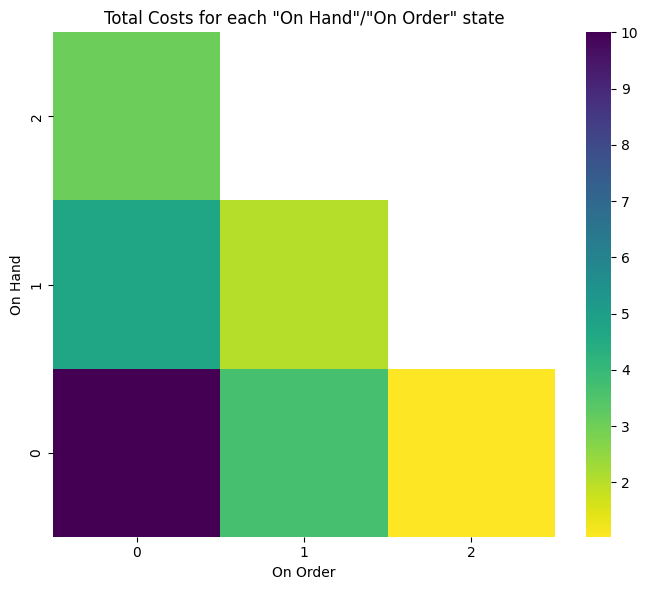

In [10]:
plt.subplots(figsize=(7, 6))
sns.heatmap(data=stats, cmap="viridis_r")
plt.title('Total Costs for each "On Hand"/"On Order" state')

plt.tight_layout()

In [11]:
# generate the value function (discounted accumulation of future rewards for a given state)
value_function = mrp.compute_value_function_vector(gamma=0.9, pprint=True)

print("===== Value Function =====")
for state, reward in value_function.items():
    print(f"{state}: reward = {reward:.3f}")

===== Value Function =====
Inventory(on_hand=0, on_order=0): reward = -43.596
Inventory(on_hand=0, on_order=1): reward = -37.971
Inventory(on_hand=0, on_order=2): reward = -37.329
Inventory(on_hand=1, on_order=0): reward = -38.971
Inventory(on_hand=1, on_order=1): reward = -38.329
Inventory(on_hand=2, on_order=0): reward = -39.329


In [12]:
# generate the reward function (expected immediate reward for a given state)
reward_vector = mrp.reward_function_vector

print("\n===== Reward Function =====")
for state, reward in zip(mrp.non_terminal_states, reward_vector):
    print(f"{state.state}: reward = {reward:.3f}")


===== Reward Function =====
Inventory(on_hand=0, on_order=0): reward = -10.000
Inventory(on_hand=0, on_order=1): reward = -3.679
Inventory(on_hand=0, on_order=2): reward = -1.036
Inventory(on_hand=1, on_order=0): reward = -4.679
Inventory(on_hand=1, on_order=1): reward = -2.036
Inventory(on_hand=2, on_order=0): reward = -3.036


## Conclusion:         
The value function is highest for `Inventory(on_hand=0, on_order=2)` and so is the reward function. This means that both the total future reward as well as the short-term expected reward for that state are the least for that state - so we should stick to that state as much as possible. In short, we should just order 2 cycles to arrive after 36 hours.